In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import sys
sys.path.append('/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/')
import ebtel2fl_plot as ebp
reload(ebp)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel2fl_plot' from '/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/ebtel2fl_plot.pyc'>

#Heating Statistics in EBTEL

Here, we want to determine how many events $\mathcal{N}$ we need to include in our distribution such that our actual power-law index $\alpha_D$ is actually representative of our chosen power-law index $\alpha$. We start be defining a function for the power law distribution that accepts a variable $x$ chosen from a uniform distribution.

In [2]:
def pl_dist(a0,a1,alpha,x):
        return ((a1**(alpha+1) - a0**(alpha+1))*x + a0**(alpha+1))**(1/(alpha+1))

Now let's choose some reasonable limits for our distribution as well as an index. We will use these throughout.

In [3]:
a0 = 0.05
a1 = 0.5
alpha = -2.0

Now choose a vector $x_0$ with 1000 entries all chosen from a uniform distribution and construct our power-law relation.

No file specified. Variable namespace will not be populated.


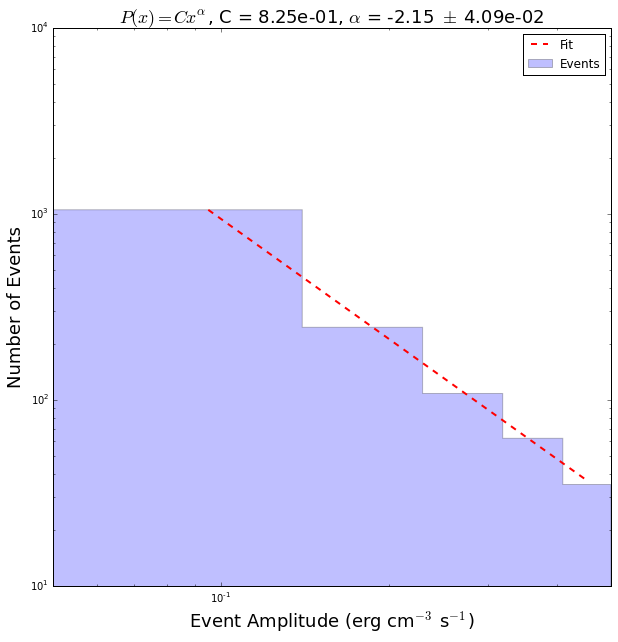

(-2.1470278547314212, 0.040900785398958736)

In [4]:
pl_plotter = ebp.Plotter()
np.random.seed()
x0 = np.random.rand(1500)
pl_plotter.events = pl_dist(a0,a1,alpha,x0)
pl_plotter.plot_event_distribution()

So 1500 events does a decent job of fitting our distribution, but we would like to do better. Let's iterate on the sample size and find a sample that does a better job; an optimal number of events will fit the distribution well within some error $\epsilon$ for our three values of $\alpha=-1.5,-2.0,-2.5$.

In [5]:
def alpha_iterator(pl_instance,a0,a1,alpha,n):
    np.random.seed()
    x0 = np.random.rand(n)
    pl_instance.events = pl_dist(a0,a1,alpha,x0)
    alpha,sigma = pl_instance.plot_event_distribution(no_show=True)
    return alpha,sigma

In [6]:
n = np.logspace(3,7,100)
n = [int(i) for i in n]
pl_indices=[-1.5,-2.0,-2.5]
#alpha-1.5
alpha15_list = []
sigma15_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[0],n[i])
    alpha15_list.append(np.fabs(alpha_temp)),sigma15_list.append(np.fabs(sigma_temp))
#alpha=2.0
alpha20_list = []
sigma20_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[1],n[i])
    alpha20_list.append(np.fabs(alpha_temp)),sigma20_list.append(np.fabs(sigma_temp))
#alpha=2.5
alpha25_list = []
sigma25_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[2],n[i])
    alpha25_list.append(np.fabs(alpha_temp)),sigma25_list.append(np.fabs(sigma_temp))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


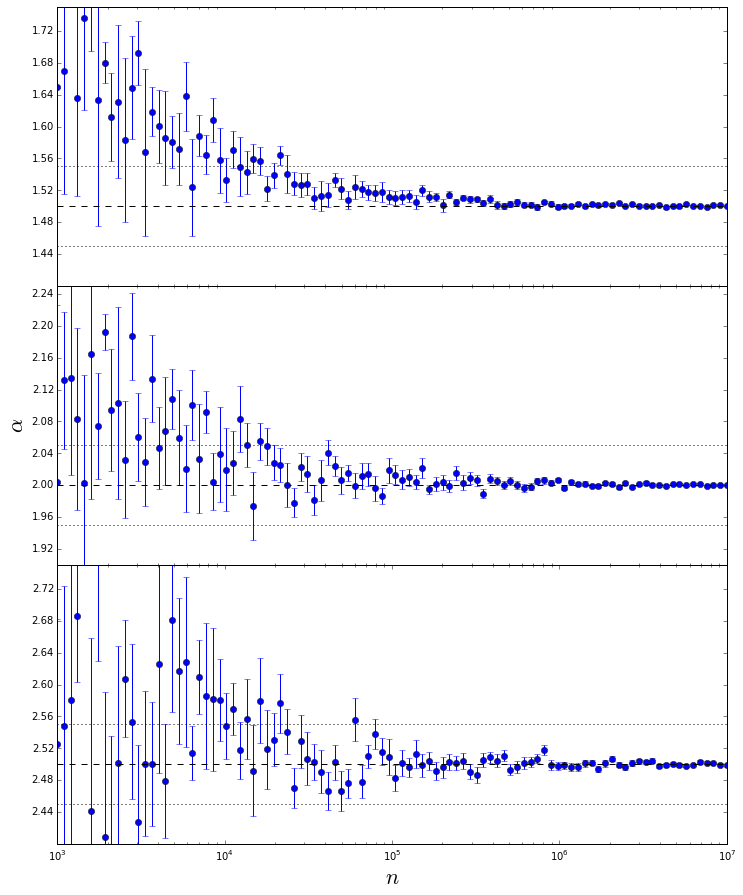

In [7]:
fig,ax = plt.subplots(3,1,figsize=(12,15))
plt.subplots_adjust(hspace=0.0)
alphas = [alpha15_list,alpha20_list,alpha25_list]
sigmas = [sigma15_list,sigma20_list,sigma25_list]
for i in range(len(pl_indices)):
    ax[i].errorbar(n,alphas[i],yerr=sigmas[i],fmt='bo')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i]),np.fabs(pl_indices[i])],'--k')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i])-0.05,np.fabs(pl_indices[i])-0.05],':k')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i])+0.05,np.fabs(pl_indices[i])+0.05],':k')
    ax[i].set_xscale('log')
    ax[i].yaxis.set_major_locator(MaxNLocator(prune='lower'))
    ax[i].set_xlim([n[0],n[-1]])
    ax[i].set_ylim([np.fabs(pl_indices[i])-0.1,np.fabs(pl_indices[i])+0.25])
    if i <(len(pl_indices)-1):
        ax[i].set_xticks([])
ax[1].set_ylabel(r'$\alpha$',fontsize=22)
ax[2].set_xlabel(r'$n$',fontsize=22)
plt.show()

The resulting histograms for $n=5\times10^3$ are shown below.

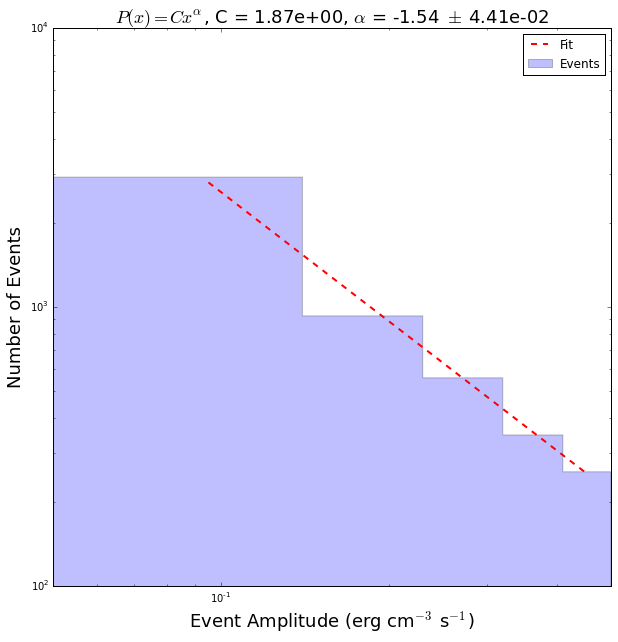

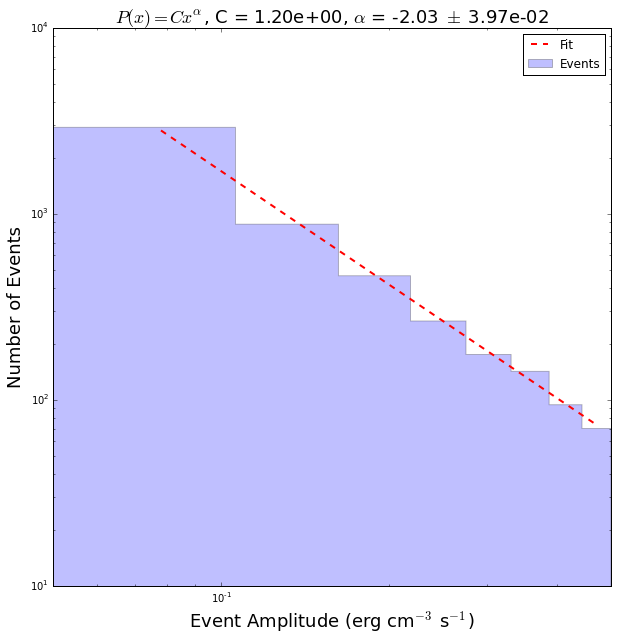

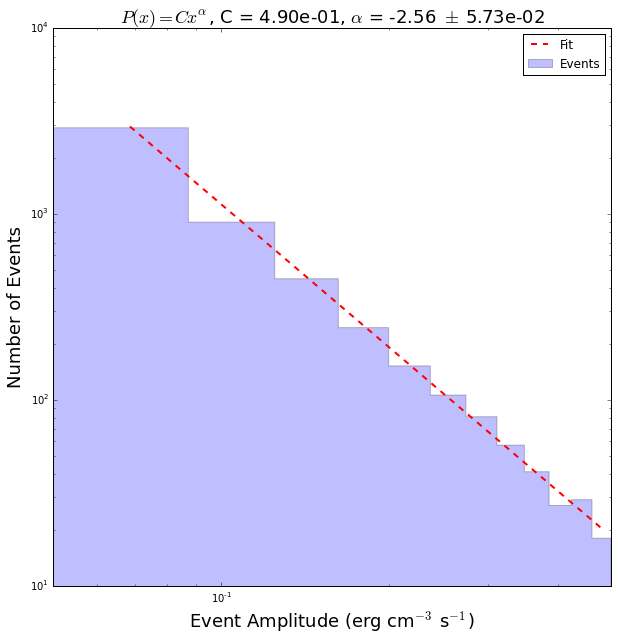

In [10]:
np.random.seed()
x0 = np.random.rand(5000)
for i in range(len(pl_indices)):
    pl_plotter.events = pl_dist(a0,a1,pl_indices[i],x0)
    pl_plotter.plot_event_distribution()

Thus, we can see that after $n\approx10^4$, most significant fluctuations have died down and our power-law index accurately represents our distribution. Thus, for each $\{\alpha,L,T_n\}$ parameter space point, we want to have at least $10^5$ events total when calculating our mean EM curves. Bearing in mind that $N$, the number of events per run, varies with $T_n$, the waiting time, we need to appropriately vary $N_{MC}$, the number of runs per unique configuration file, such that $$\mathcal{N}=N\times N_{MC}\ge10^5.$$ 

We calculate our number of events using the the formula $$N=\frac{T_{total}}{t_{pulse}+T_n},$$where $T_{total}$ is the total simulation time and $t_{pulse}$ is the duration of each heating pulse, assumed to be uniform for the cases we are considering. Now, we can, using our threshold $\mathcal{N}$ value calculated above, find the optimal $N_{MC}$ value for each value of $T_n$. 

In [11]:
def calc_total_events(t_tot,t_pulse,t_n,N_tot):
    N_N = int(np.ceil(t_tot/(t_pulse+t_n)))
    N_MC = int(np.ceil(N_tot/N_N))
    return N_N,N_MC

In [15]:
#define some typical parameters
ttotal = 8.0e+4
tpulse = 1.0e+2
tn = np.arange(250,5250,250)
N_tot = 5.0e+3

In [16]:
#iterate over tn values
nn_list = []
nmc_list = []
for i in range(len(tn)):
    nn_temp,nmc_temp = calc_total_events(ttotal,tpulse,tn[i],N_tot)
    nn_list.append(nn_temp),nmc_list.append(nmc_temp)

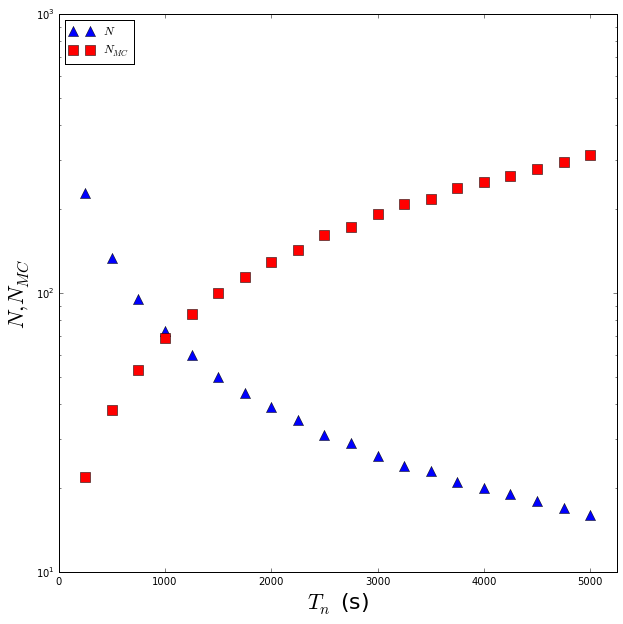

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(tn,nn_list,'^',markersize=10,label=r'$N$')
ax.plot(tn,nmc_list,'rs',markersize=10,label=r'$N_{MC}$')
ax.set_xlabel(r'$T_n$ (s)',fontsize=22)
ax.set_ylabel(r'$N,N_{MC}$',fontsize=22)
ax.legend(loc=2)
ax.set_yscale('log')
ax.set_xlim([0,tn[-1]+(tn[1]-tn[0])])
plt.show()

Thus, the total number of runs we will need per $\{\alpha,L\}$ parameter space point is:

In [18]:
#sum up the lists
total_runs = sum(nmc_list)
print "The total number of runs we will need to perform per (alpha,L parameter space point is) ",total_runs

The total number of runs we will need to perform per (alpha,L parameter space point is)  3346
